# *Tetrahedra FE pipeline - dental bracket assembly; heterogeneous materials*

Created on:  07.07.2023 <br />
Last update: 14.07.2023 <br />

- By: [Gianluca Iori](https://github.com/gianthk), 2023
- Sample origin: the sample used in this example is courtesy of Dr. Petra Koch, [Dep. of Orthodontics and Dentofacial Orthopedics, Charité – Universitätsmedizin Berlin](https://kieferorthopaedie.charite.de/en/metas/person_detail/person/address_detail/petra_julia_koch/).
- Data source: the synchrotron tomogrphy dataset for this example was obtained during the [BEATS X-ray tomography lectures and training course at SESAME](https://indico.sesame.org.jo/event/4/), SESAME Allan (Jordan) 6th and 7th June 2023.
- Code license: MIT
- Narrative license: CC-BY-NC-SA

![Tooth bracket_mesh](./../../test_data/tooth/Transbond_XT_35c_3D.png)
<p style="text-align: center;"> <em> Synchrotron X-ray microCT scan of dental bracket - 3D rendering </em> </p>

---
# Aims
The example implements the following ciclope pipeline:
1. Load and inspect binary masks of enamel, glue, cement, and dental bracket regions
2. Simulate steel pliers holding the tooth bracket
3. Extend enamel mask until image boundary
4. Generate 3D Unstructured Grid mesh of tetrahedra
5. Generate tetrahedra-FE model for simulation in CalculX or Abaqus from 3D Unstructured Grid mesh 
    - Linear-elastic, displacement-driven static analysis with the following boundary conditions:
        - Tooth material fully constrained
        - Displacement imposed closing the steel pliers from both sides - lateral compression load transferred to the bracket 
    - Heterogeneous material mapping (assign one material card to each dataset grey value)
6. Launch simulation in Calculix. For info on the solver visit the [Calculix homepage](http://www.calculix.de/)
7. Convert Calculix output to .VTK for visualization of results (e.g. Von Mises stress field) in Paraview

Type `python ciclope.py -h` to display the ciclope help with a full list of available command line arguments.

---
# Preliminary operations
The following image processing steps were performed in FIJI ImageJ:
1. Load Synchrotron microCT volume data of a tooth bracket
2. 3D image crop
3. Median filter (2 voxels kernel)
4. FFT bandpass (min feature: 24, max feature: 2000)
5. Image scale (scaling factor: 0.2, bilinear interpolation)
6. 2D image rotation along Z-axis (-15.54 deg, bilinear interpolation)
7. Segmentation (8 bit)
	1. Enamel (BW>204, fill holes, keep largest, dilate)
	2. Tooth bracket (BW>152, subtract dilated enamel, clear south, keep largest, fill holes, erode (2x), dilate (3x))
	3. Cement+Glue (97>BW>170, subtract dilated bracket, clear south, open, keep largest)
	4. Glue (dilate enamel (4x))
    5. Cement = (Cement+Glue) - Glue
    
---
## To do
- Separate surface node set on enamel (contact dental glue - enamel)
- Extract stresses on enamel surface
- Rotate image in 3D (simulate better pliers alignment)

---
# Computational workflow
## Configuration and imports

In [44]:
import sys
sys.path.append('./../../')

In [4]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import dxchange 

from ciclope.utils.recon_utils import plot_midplanes, plot_projections, bbox, read_tiff_stack
from ciclope.utils.preprocess import fill_voids, embed, add_cap
from ciclope import tetraFE

matplotlib.rcParams['figure.dpi'] = 300

font = {'weight' : 'normal',
        'size'   : 8}

plt.rc('font', **font)

#### Load input data

|Scan parameters|   |
|:-|:-|
|Beamline|ID10-BEATS@SESAME|
|Scan modality|Filtered white beam|
|Energy (average)|35 keV|
|Sample|Bovine teeth - ceramic bracket|
|Detector|Hasselblad ESRF tandem optics (1x); ORYX FLIR 7.1MP camera|
|Voxel size|4.5 micron|
|Scan time|~ 40 s|


In [5]:
work_folder = '/home/gianthk/Data/BEATS/Petra_charite/Transbond_XT_35c-20230615T150415/recon_crop_fft_scale_rot/'
filepath = work_folder+'mask/'

In [6]:
braket_data = filepath+'bracket3/slice_0000.tif'
cement_data = filepath+'cement3/slice_0000.tif'
glue_data = filepath+'glue/slice_0000.tif'
enamel_data = filepath+'enamel/slice_0000.tif'

In [48]:
bracket_3D = 1*(read_tiff_stack(braket_data)>1).astype('uint8')
cement_3D = 2*(read_tiff_stack(cement_data)>1).astype('uint8')
glue_3D = 3*(read_tiff_stack(glue_data)>1).astype('uint8')
enamel_3D = 4*(read_tiff_stack(enamel_data)>1).astype('uint8')

vs = np.ones(3)*4.5e-3/0.2 # [mm]

#### The goal is to create a 3D image of the tooth - dental bracket assembly, assigning a different scalar value to each material:
1. bracket (we will assume this is aluminum)
2. cement
3. glue
4. enamel (tooth)
5. steel pliers

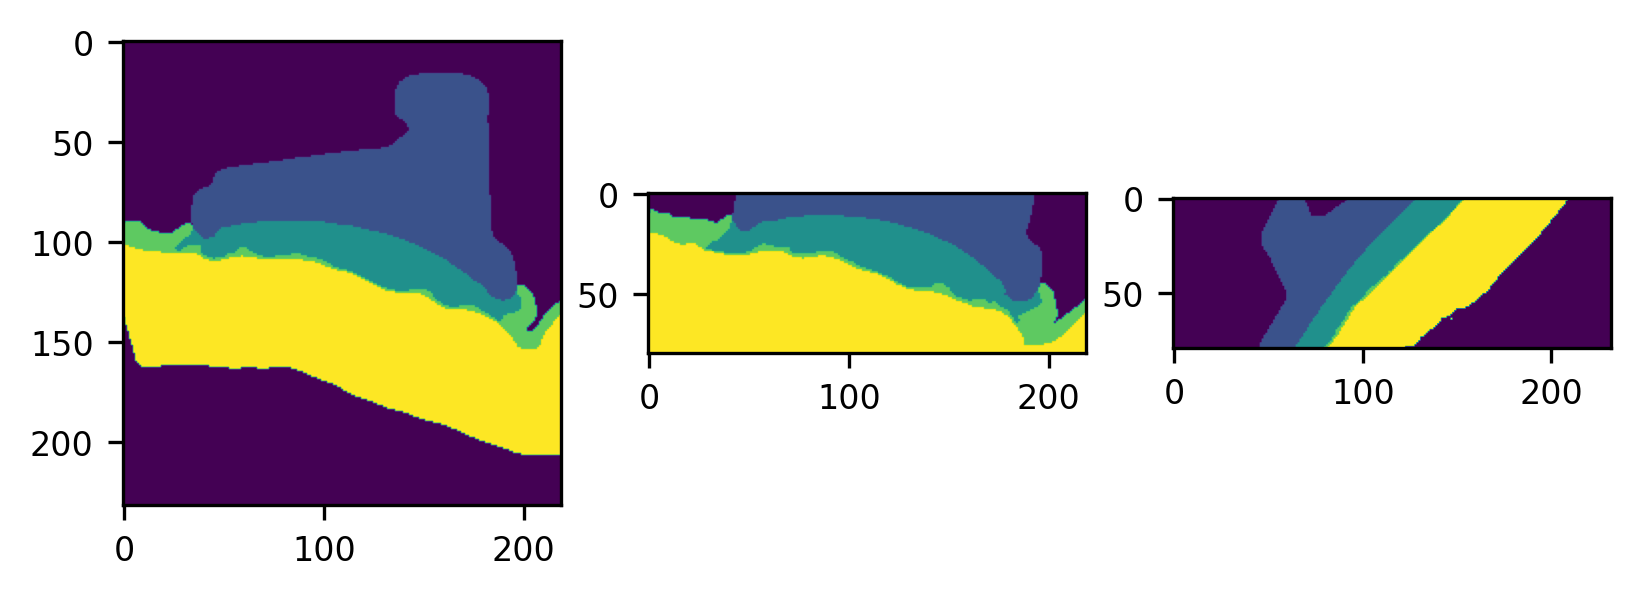

In [49]:
plot_midplanes(bracket_3D+cement_3D+glue_3D+enamel_3D)

## Pre-processing
### Extend tooth towards south
Extend tooth material (enamel for simplicity) towards the south area of the image.
The method `ciclope.utils.preprocess.embed` allows to embed a 3D image from a chosen direction and to specify the Grey Value of the embedding material. For a full list of embedding parameters see the method help typing:  

In [50]:
help(embed)

Help on function embed in module ciclope.utils.preprocess:

embed(I, embed_depth, embed_dir, embed_val=None, pad=0, makecopy=False)
    Add embedding to 3D image.
    Direction and depth of the embedded region should be given. Zeroes in the input image is considered to be background.
    
    Parameters
    ----------
    I
        3D data. Zeroes as background.
    embed_depth : int
        Embedding depth in pixels.
    embed_dir : str
        Embedding direction. Can be "-x", "+x", "-y", "+y", "-z", or "+z".
    embed_val : float
        Embedding grey value.
    pad = int
        Padding around bounding box of embedded area.
    makecopy : bool
        Make copy of the input image.
    
    Returns
    ----------
    I
        Embedded image. Same size as the input one.
    BW_embedding
        BW mask of the embedding area.



Embed from **SOUTH** along the Y-axis over 120 image voxels. Assign `embed_val = 4` to the embedding material:

In [51]:
data_for_meshing_embedded, BW_embedding_tooth = embed(bracket_3D+cement_3D+glue_3D+enamel_3D, 100, "+y", embed_val=4, makecopy=True)

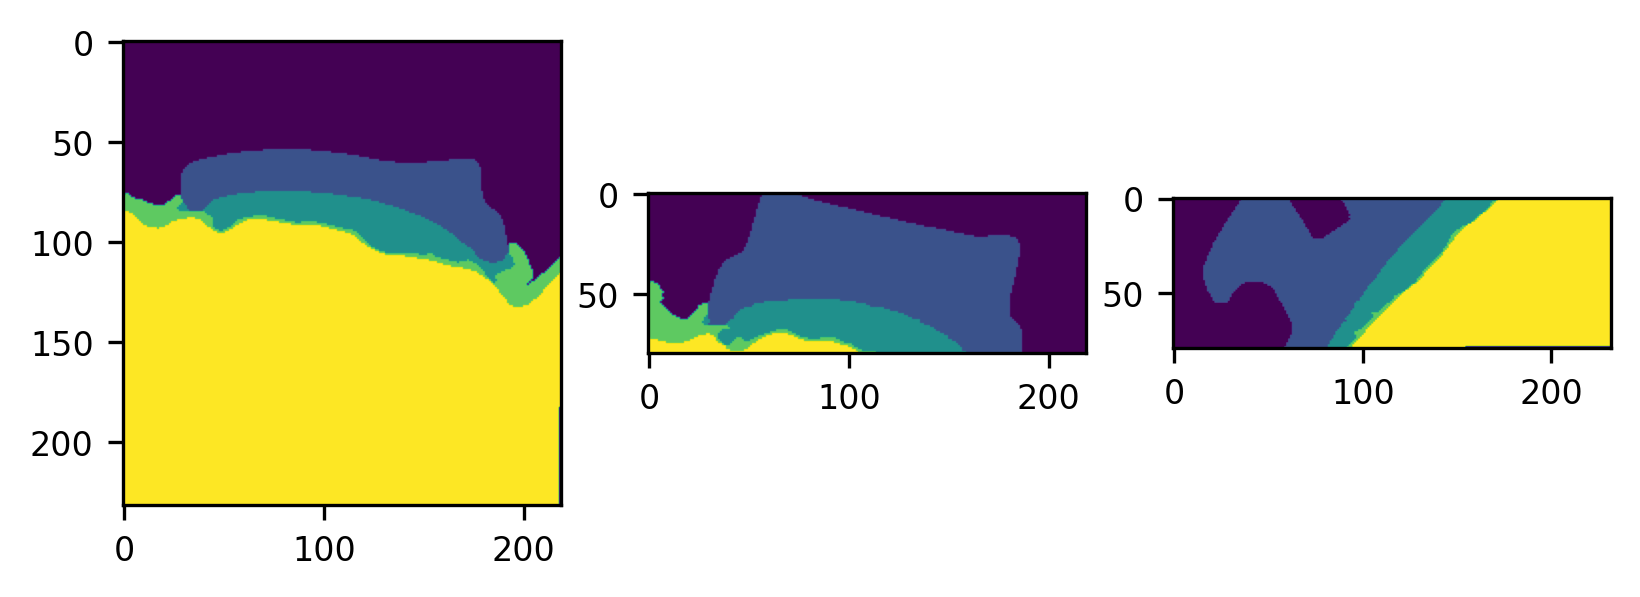

In [52]:
plot_midplanes(data_for_meshing_embedded, 160,80,60)

#### Remove 10 rows on **WEST** and **EATS** borders

In [53]:
data_for_meshing_embedded[:,:,:10] = 0
data_for_meshing_embedded[:,:,-10:] = 0

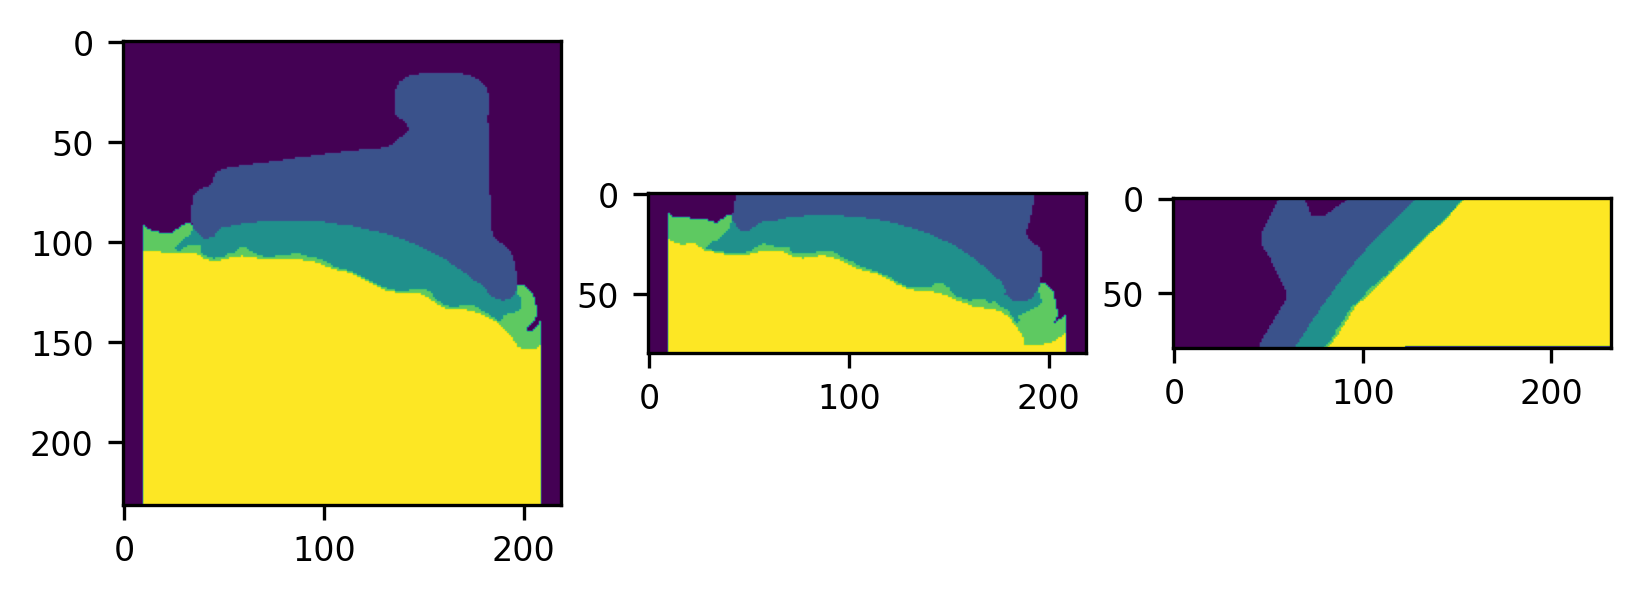

In [54]:
plot_midplanes(data_for_meshing_embedded)

#### Create mask of steel pliers

In [55]:
pliers_3D = np.zeros(data_for_meshing_embedded.shape, 'uint8')

In [56]:
pliers_3D[:30,62:76,:62] = 5
pliers_3D[30:51,57:84,177:] = 5

In [57]:
pliers_3D[data_for_meshing_embedded!=0] = 0

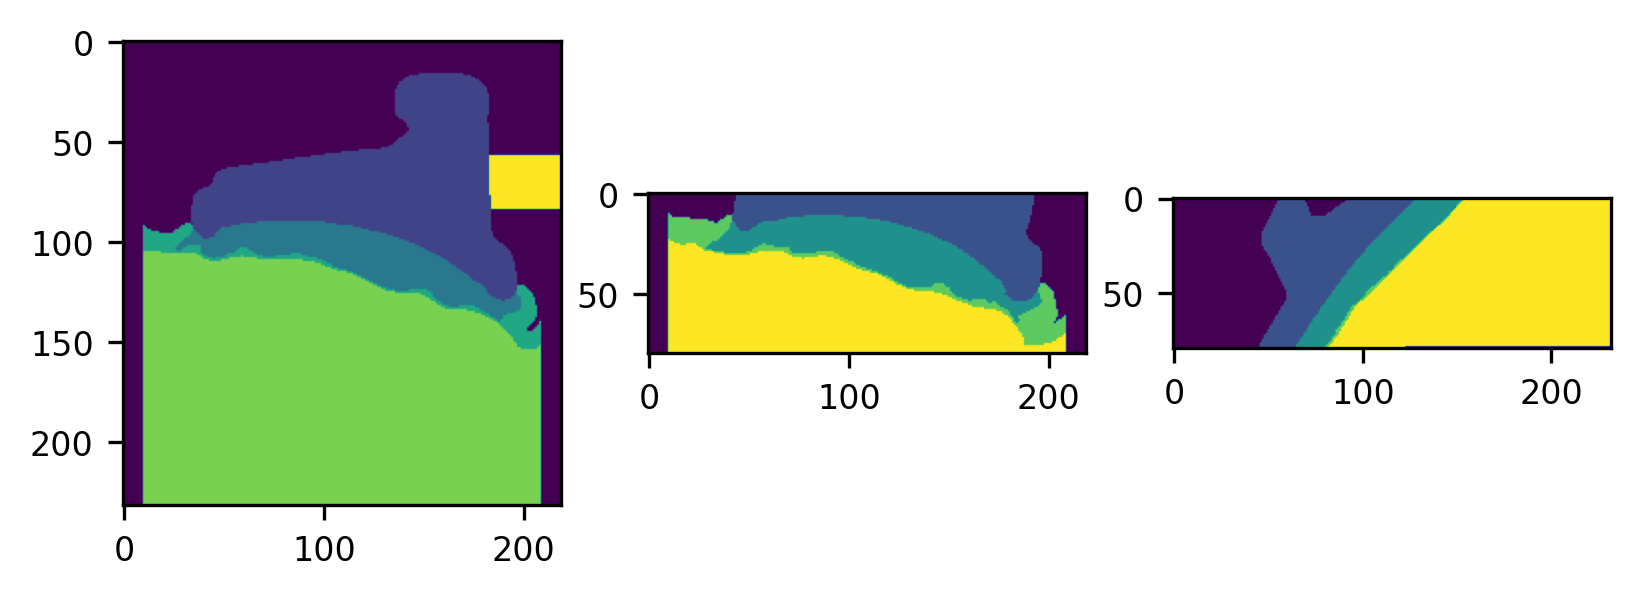

In [58]:
plot_midplanes(pliers_3D+data_for_meshing_embedded)

In [59]:
data_for_meshing_embedded = pliers_3D+data_for_meshing_embedded

Save data for meshing as TIFF stack

In [60]:
meshing_data = filepath+'for_meshing/slice_0000.tif'

In [ ]:
# dxchange.writer.write_tiff_stack(data_for_meshing_embedded,
#                                  fname=meshing_data,
#                                  dtype='uint8',
#                                  axis=0,
#                                  digit=4,
#                                  start=0,
#                                  overwrite=True)

## Create tetrahedra mesh
Volume meshing using [CGAL](https://www.cgal.org/) through [pygalmesh](https://github.com/nschloe/pygalmesh)

In [41]:
filename_mesh_out = work_folder+'fe/Transbond_XT_35c_tetra.vtk'

Reduce the `mesh_size_factor` (keeping it small for fast execute)

In [42]:
mesh_size_factor = 0.9

In [ ]:
mesh = tetraFE.cgal_mesh(data_for_meshing_embedded, vs, 'tetra', mesh_size_factor * min(vs), 3* mesh_size_factor * min(vs))

![Tooth bracket_mesh](./../../test_data/tooth/Transbond_XT_35c_tetra.png)
<p style="text-align: center;"> <em> Heterogeneous material mesh: (1) bracket, (2) cement, (3) glue, (4) tooth, (5) steel pliers. </em> </p>

## Write Abaqus input FE files
### Generate tetrahedra-FE model with multiple material properties
The method `ciclope.core.tetraFE.mesh2tetrafe` assumes that the material property definition is contained in the FE analysis `.INP` template file.

In [1]:
input_template = "./../../input_templates/tmp_example06_comp_static_dental_bracket.inp"

Inspect input template file:

---
#### Material properties
The first section of the input template contains material definitions for the four materials of the model

|#ID |Component |Material |E  [MPa] |v |Ref. |
|:-|:-|:-|:-:|:-:|:-|
|1. |Bracket |Aluminum |70.0 |0.334 | |
|2. |Cement |H poly |2200.0 |0.3 |[L Ahmadian et al.](https://brieflands.com/articles/zjrms-94390.html) |
|3. |Glue |Resin dental Clearfil SE Bond |4700.0 |0.3 |[A Takahashi et al.](https://pubmed.ncbi.nlm.nih.gov/11823019/) |
|4. |Tooth |Enamel |1338.2 |0.3 | |
|5. |Pliers |Steel |210.0 |0.333 | |

---
#### Boundary conditions
The next section defines a static linear-step analysis with the following boundary conditions:
- Displacement along X, Y, Z = 0 for all nodes on the model **SOUTH** surface (NODES_Y1; tooth boundary)
- +0.1 mm displacement imposed along X on all nodes on the model **WEST** surface (NODES_X0; left plier)
- -0.1 mm displacement imposed along X on all nodes on the model **EAST** surface (NODES_X1; right plier)

In [2]:
!cat {input_template} # on linux

** User material property definition:
** ---------------------------------------------------
** ENAMEL
** ---------------------------------------------------
*SOLID SECTION, ELSET=SET4, MATERIAL=ENAMEL
1.
*MATERIAL,NAME=ENAMEL
*ELASTIC
1338.2, 0.3
** ---------------------------------------------------
** CEMENT H poly - https://brieflands.com/articles/zjrms-94390.html
** ---------------------------------------------------
*SOLID SECTION, ELSET=SET2, MATERIAL=CEMENT
1.
*MATERIAL,NAME=CEMENT
*ELASTIC
2200., 0.3
** ---------------------------------------------------
** Resin dental Clearfil SE Bond - https://pubmed.ncbi.nlm.nih.gov/11823019/
** ---------------------------------------------------
*SOLID SECTION, ELSET=SET3, MATERIAL=RESIN
1.
*MATERIAL,NAME=RESIN
*ELASTIC
4700., 0.3
** ---------------------------------------------------
** STEEL
** ---------------------------------------------------
*SOLID SECTION, ELSET=SET5, MATERIAL=STEEL
1.
*MATERIAL,NAME=STEEL
*ELASTIC
210., 0.333
** -

In [7]:
filename_out = work_folder+'fe/Transbond_XT_35c_tetra.inp'

Generate CalculiX FE input file

In [ ]:
tetraFE.mesh2tetrafe(mesh, input_template, filename_out, keywords=['NSET', 'ELSET'])

## Solve FE model in calculix
The following section assumes that you have the Calculix solver installed and accessible with the command `ccx_2.17` or for multithread option `ccx_2.17_MT`. <br />
The multithread option in CalculiX is activated by defining the number of threads (default=1) used for the calculation.<br />
This is done by setting the env variable *OMP_NUM_THREADS* with:
`export OMP_NUM_THREADS=8`

In [ ]:
!export OMP_NUM_THREADS=8; ccx_2.17_MT "./../../test_data/tooth/results/Tooth_3_scaled_2"

## Post-processing
### Convert Calculix output to Paraview
The following sections assume that you have **ccx2paraview** and **Paraview** installed and working.<br /> For more info visit: <br />
- [https://www.paraview.org/](https://www.paraview.org/)
- [https://github.com/calculix/ccx2paraview](https://github.com/calculix/ccx2paraview)

In [9]:
import os
import ccx2paraview

In [10]:
filename_out_base, ext_out = os.path.splitext(filename_out)

In [ ]:
ccx2paraview.Converter(filename_out_base + '.frd', ['vtk']).run()

### Visualize results in Paraview
- Max. Z-displacement: xxx mm
- Max. Von Mises stress: xxx MPa

In [28]:
!paraview {filename_out_base + '.vtk'}

![Tooth bracket_Smises](./../../test_data/tooth/Transbond_XT_35c_tetra_Smises.png)

### Post-process FE analysis results
Display the CalculiX FE output `.DAT` file containing the total reaction force:

In [12]:
filename_dat = filename_out_base + '.dat'

In [ ]:
!cat {filename_dat}